In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam


In [2]:
df_CASP = pd.read_csv ("CASP.csv")
id_names = ['Seq Name']
features1 = ['mcg','gvh','alm','mit','erl','pox','vac','nuc']
class_names = ['class']

columns_names = id_names + features1 + class_names

df_YEAST = pd.read_csv("yeast.data",names=columns_names,sep='\s+')


# PROBLEMA DE CLASIFICACIÓN: YEAST DATASET

Lo primero que se hará es un analisis exploratorio de datos para poder encarar el problema de clasificacióm. Se verá el balance de clases, se conseguirán las metricas principales de los atributos, se verán los histogramas de los atributos para analizar su distribución, tanto sin separar como separando por clase.

## Análisis exploratorio de datos

### Metricas de los atributos

In [3]:
def GetMetricas(df_):

    media = df_.mean()
    mediana = df_.median()
    desvio = df_.std()
    atributos = list(media.index)
    dicc = {'Atributos': atributos}
    metricas = pd.DataFrame(dicc)
    metricas["Media"] = np.array(media)
    metricas["Mediana"] = np.array(mediana)
    metricas["Desvio"] = np.array(desvio)
    
    return metricas

In [4]:
metricas_CASP = GetMetricas(df_CASP)
metricas_yeast = GetMetricas(df_YEAST)
print(metricas_yeast)



  Atributos     Media  Mediana    Desvio
0       mcg  0.500121     0.49  0.137299
1       gvh  0.499933     0.49  0.123924
2       alm  0.500034     0.51  0.086670
3       mit  0.261186     0.22  0.137098
4       erl  0.504717     0.50  0.048351
5       pox  0.007500     0.00  0.075683
6       vac  0.499885     0.51  0.057797
7       nuc  0.276199     0.22  0.106491


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\990671553.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  media = df_.mean()
C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\990671553.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mediana = df_.median()
C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\990671553.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  desvio = df_.std()


In [5]:
df_YEAST.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


### Analizo el balance de clases y frecuencia relativa de cada clase

Balance de clases

In [6]:
b_clases_yeast = df_YEAST['class'].value_counts()
print(b_clases_yeast)

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: class, dtype: int64


Frecuencia relativa de cada clase

In [7]:
frec = b_clases_yeast / len(df_YEAST)
print(frec)
print(frec[0]+frec[1]+frec[2]+frec[3])
print(frec[0]+frec[1])

CYT    0.311995
NUC    0.289084
MIT    0.164420
ME3    0.109838
ME2    0.034367
ME1    0.029650
EXC    0.023585
VAC    0.020216
POX    0.013477
ERL    0.003369
Name: class, dtype: float64
0.8753369272237197
0.601078167115903


Puede notarse que hay 4 clases que representan el 87.5% de los datos (CYT, NUC, MIT, ME3)

### HISTOGRAMAS Y DISTRIBUCIÓN DE ATRIBUTOS

#### Histograma de atributos sin separación por clase

C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4282080458.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_YEAST.drop(columns = ["class","Seq Name"]).hist(ax=ax)


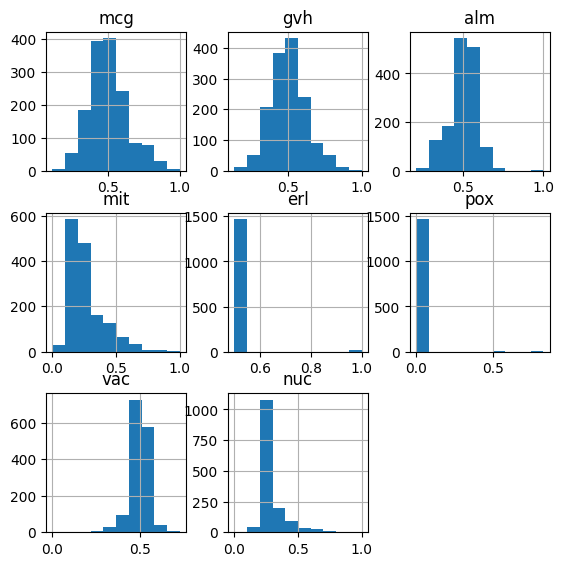

In [8]:
clases = set(df_YEAST["class"])

fig, ax =plt.subplots(figsize=(6.5,6.5))
df_YEAST.drop(columns = ["class","Seq Name"]).hist(ax=ax)
plt.show()

In [9]:
df_a = df_YEAST[df_YEAST["erl"] == 0.5]
print(df_a['class'].value_counts())
print(len(df_a))

CYT    459
NUC    426
MIT    244
ME3    162
ME2     50
ME1     44
EXC     35
VAC     30
POX     20
Name: class, dtype: int64
1470


In [10]:
df_a = df_YEAST[df_YEAST["erl"] != 0.5]
print(df_a['class'].value_counts())
print(len(df_a))

ERL    5
CYT    4
NUC    3
ME2    1
ME3    1
Name: class, dtype: int64
14


In [11]:
df_b = df_YEAST[df_YEAST["pox"] == 0.0]
print(df_b['class'].value_counts())
print(len(df_b))

CYT    462
NUC    429
MIT    241
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX      9
ERL      5
Name: class, dtype: int64
1469


In [12]:
df_b = df_YEAST[df_YEAST["pox"] !=0 ]
print(df_b['class'].value_counts())
print(len(df_b))

POX    11
MIT     3
CYT     1
Name: class, dtype: int64
15


Puede verse aqui como ERL y POX tienen el mismo valor para casi todas las muestras (erl = 0.5 y pox = 0)

#### Histograma de atributos con separación por clase

ME2


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


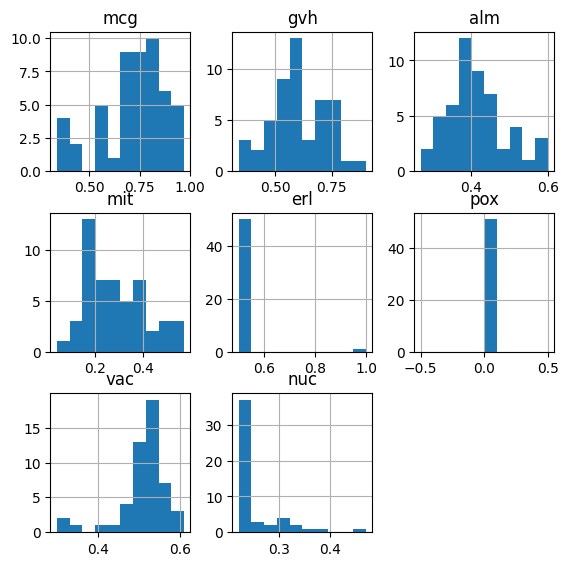

NUC


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


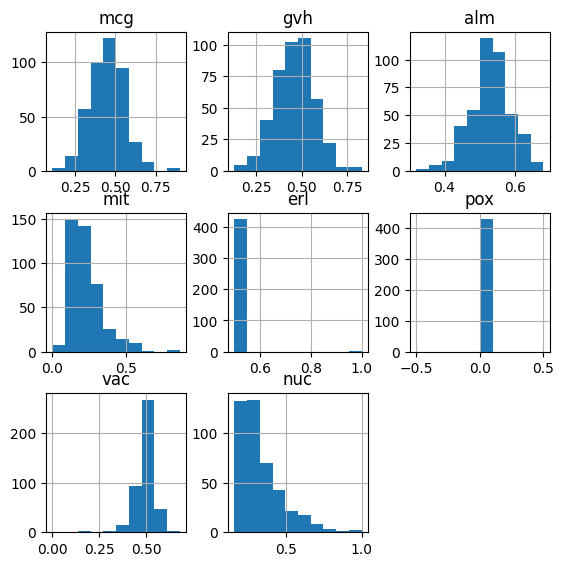

CYT


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


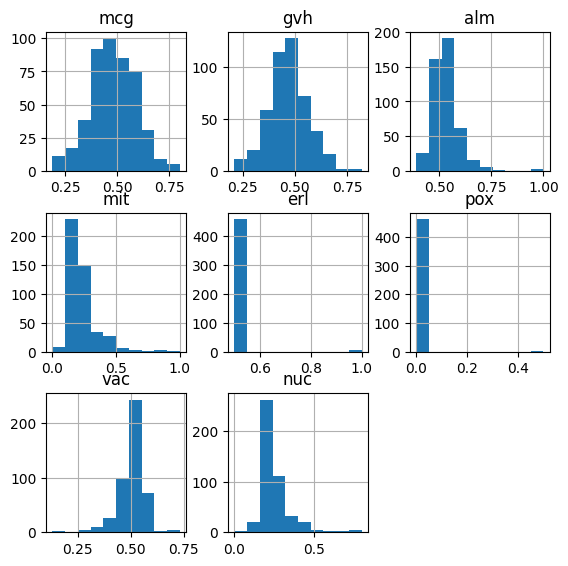

VAC


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


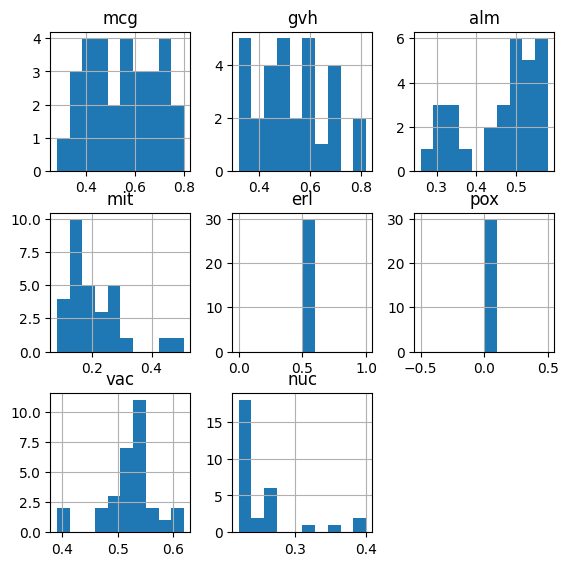

ME3


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


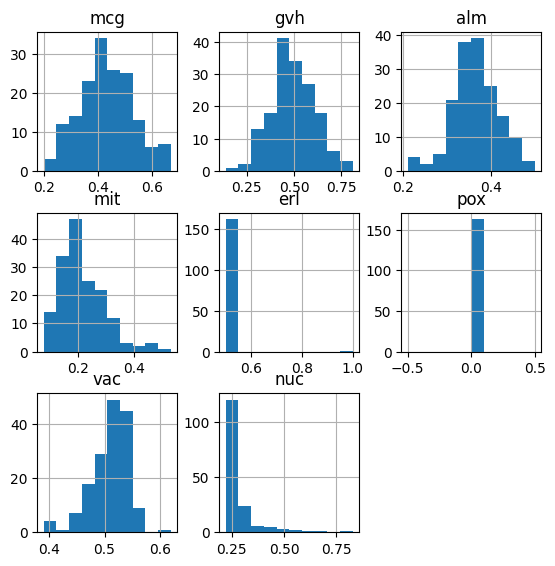

ERL


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


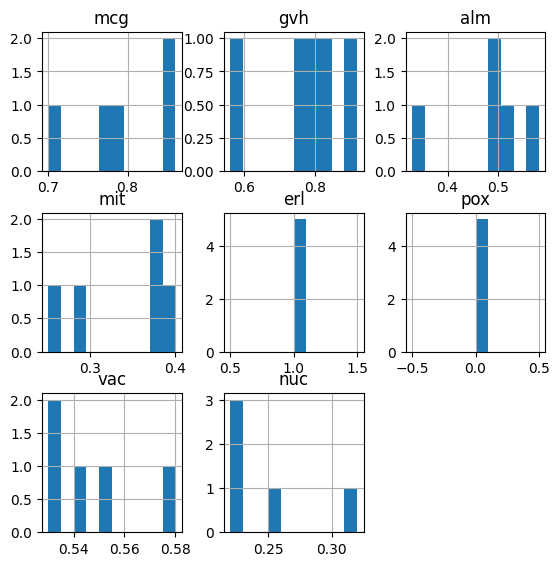

MIT


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


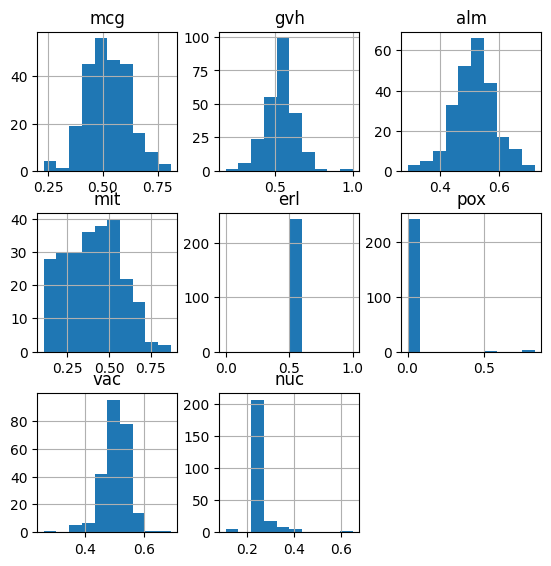

EXC


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


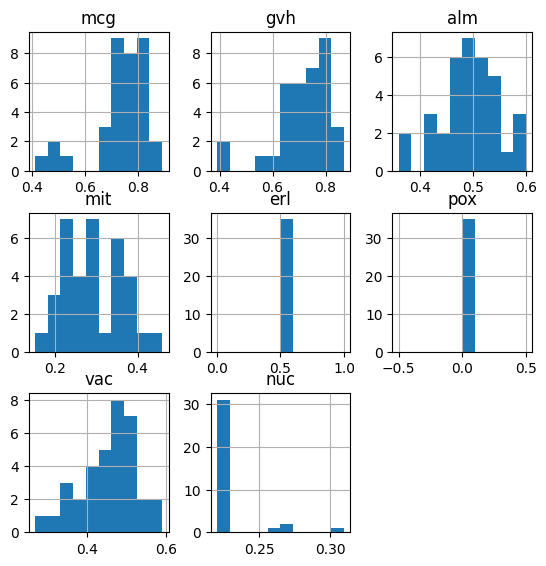

POX


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


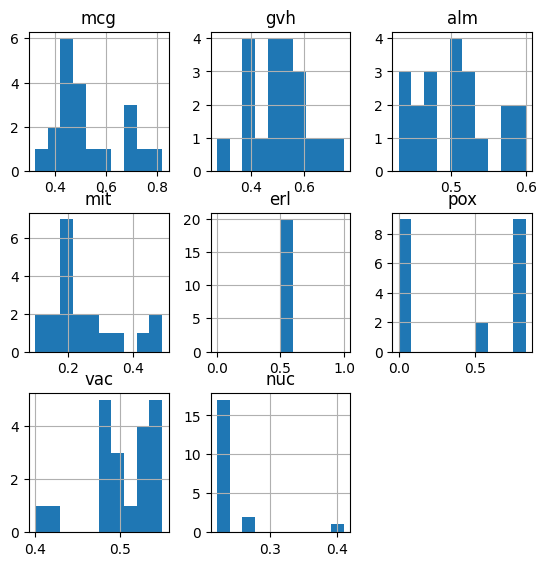

ME1


C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4258122728.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clase.hist(ax=ax)


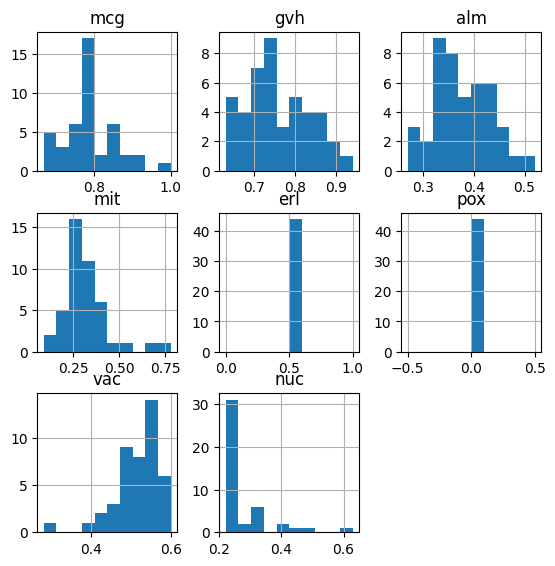

In [13]:
clases

for clase in clases:
   
    df_clase = df_YEAST.loc[df_YEAST["class"] == clase]
    df_clase = df_clase.drop(["class","Seq Name"], axis =1)
    atributos = df_clase.columns.values
    print(clase)
    
    fig, ax =plt.subplots(figsize=(6.5,6.5))
    df_clase.hist(ax=ax)
    plt.show()

Histogramas y scatterplot

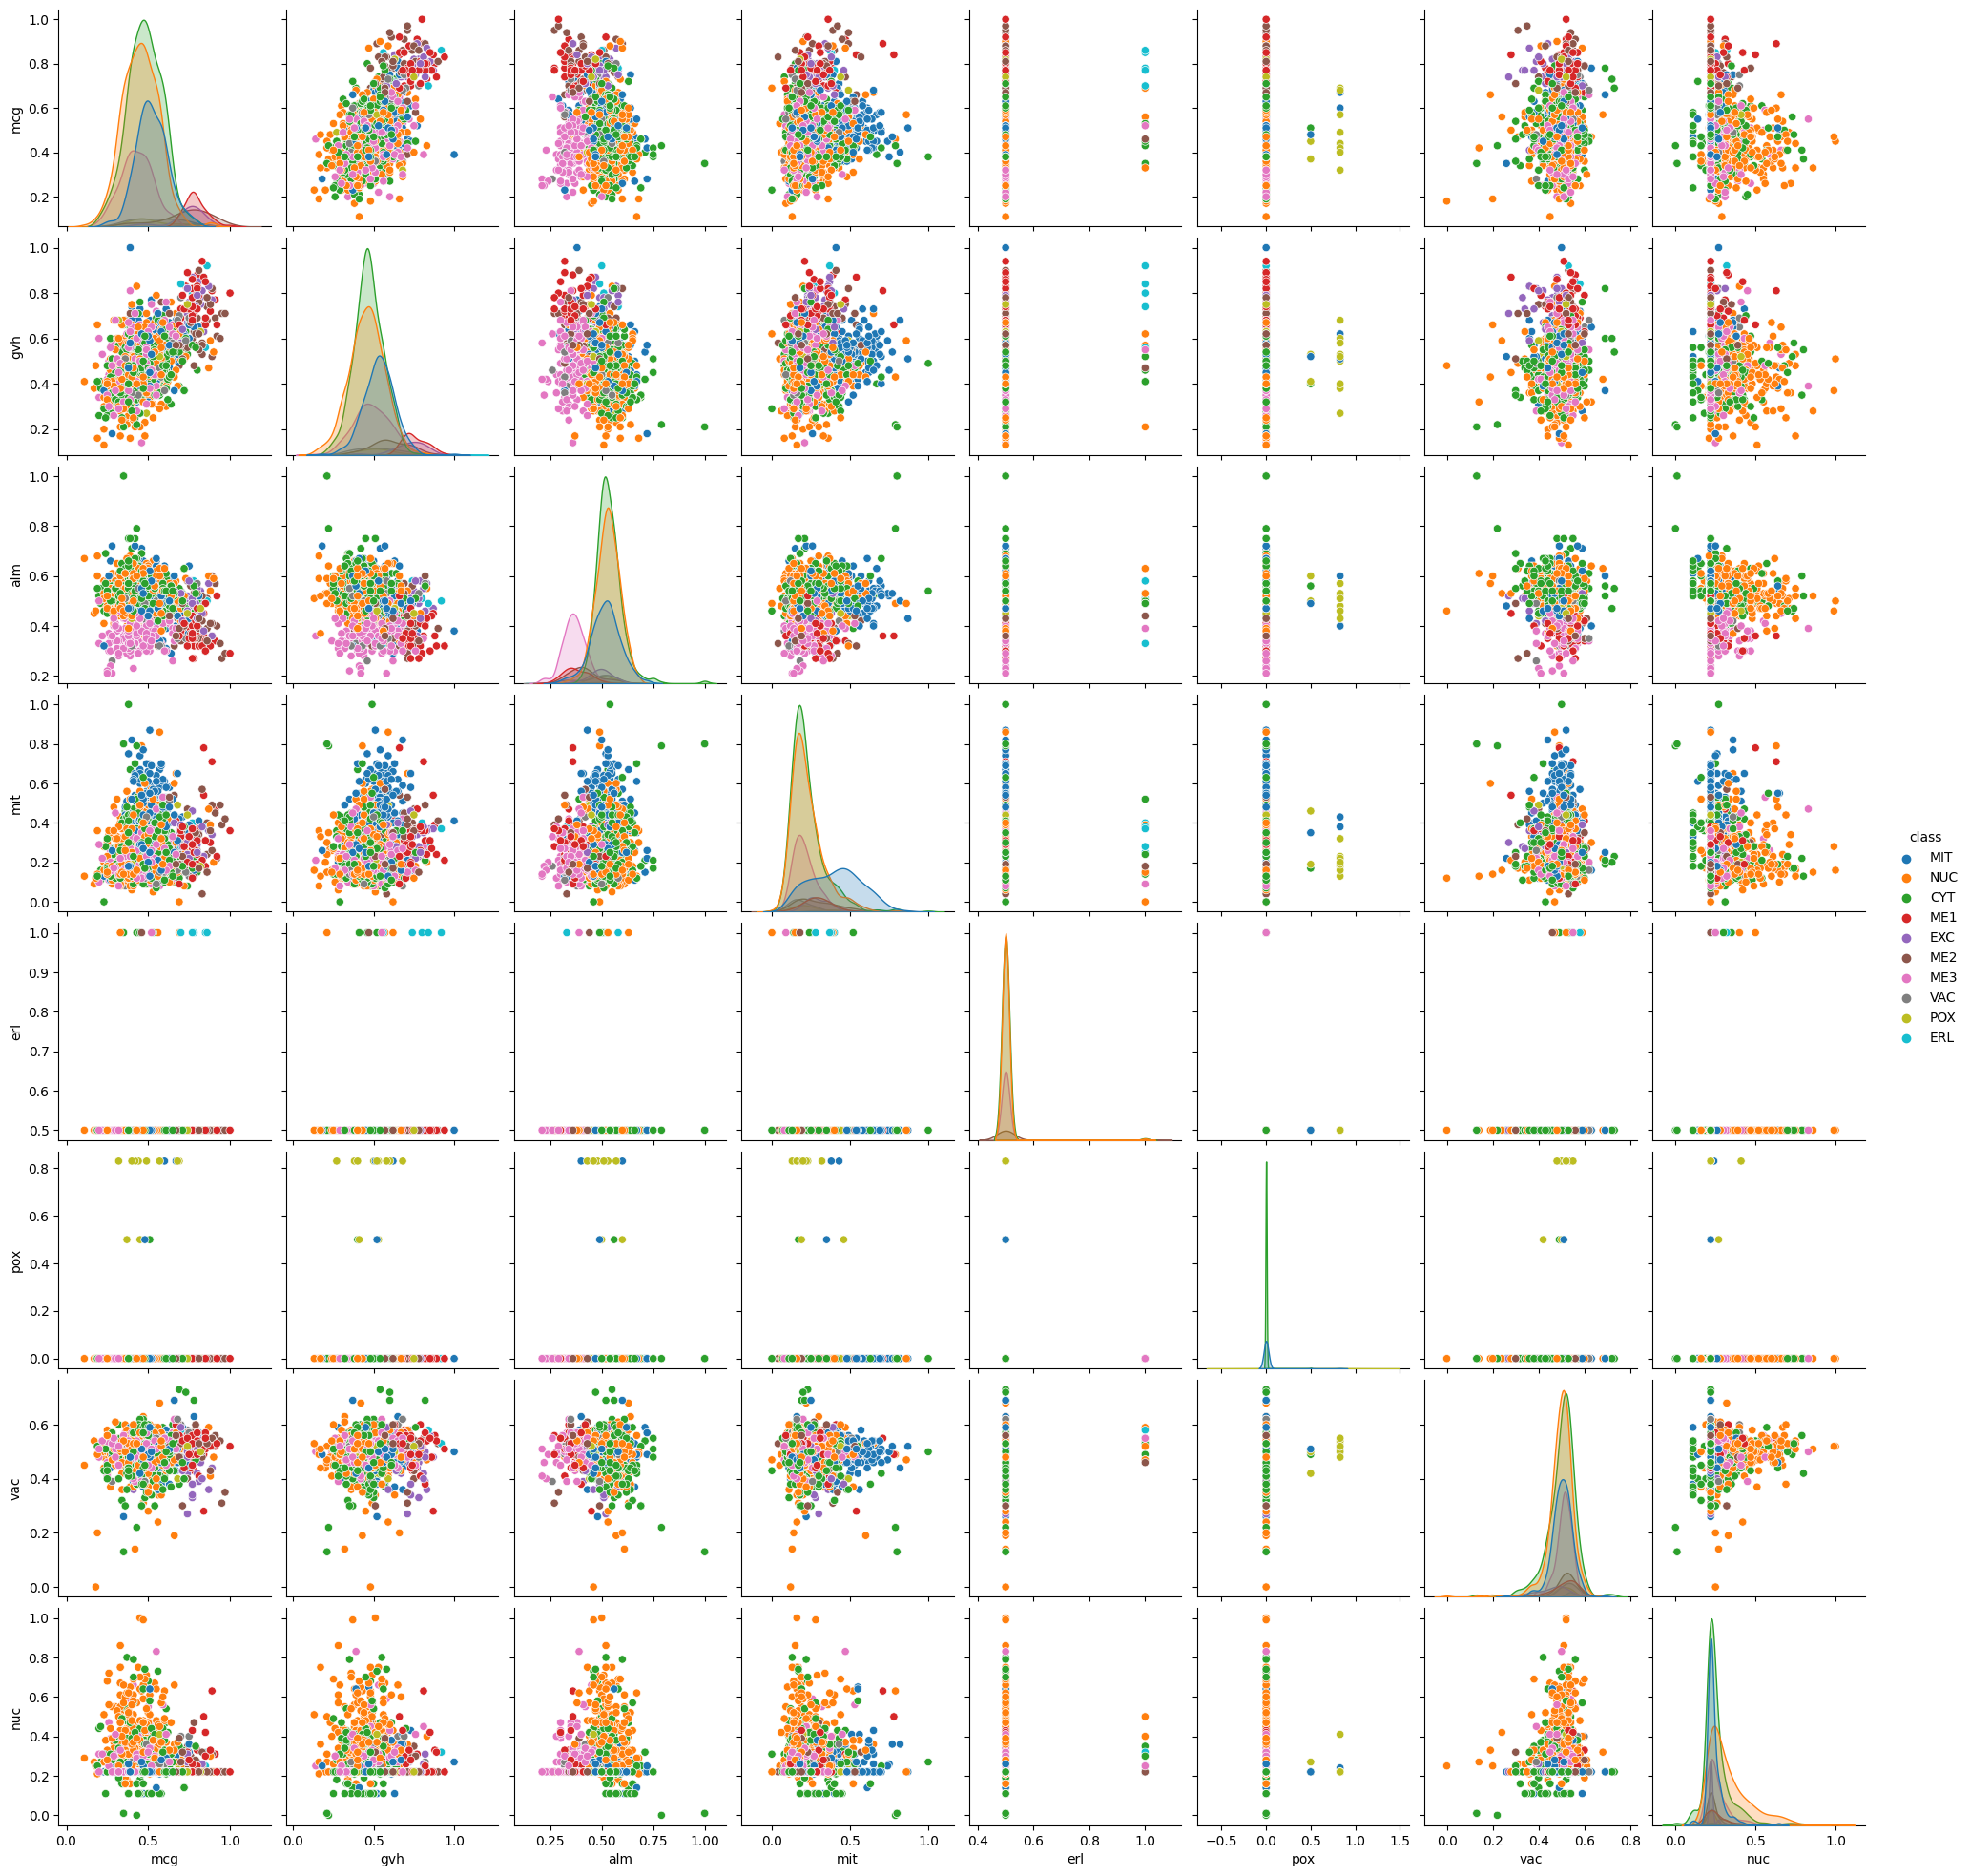

In [14]:
sns.pairplot(df_YEAST, hue = 'class')

## Conclusiones, separación y procesamiento de datos para clasificar.

### Separación de datos 

#### Elección de clases

Del análisis exploratorio de datos puede verse que las clases mas representativas son: CYT, NUC, MIT, ME3.
Juntas, representan el 87.5% de los datos. Es por esto que se eligio utilizar solamente estas 4 clases para el problema de clasificación multiclase.

Se encaró el problema de clsificación binaria de dos formas: analizar unicamente las 2 clases mas representativas y agrupar las clases mas similares en 2 grupos.

Para la primera estrategia se vio que las dos mas representativas son CYT y NUC, que engloban el 60% de los datos, por lo que solo se utilizaron estas dos clases para clasificar.

Para la estrategia de agrupar, se analizó la distribución de los atributos separado por clase. Para esto se analizaron los histogramas y scatterplots de los atributos separados por clases. En muchos parecía haber distribuciones similares para los atributos (como puede verse tambien el los scatterplots, donde no hay separacion clara de clases), aunque los mas parecidos fueron CYT, MIT (se superponen los histogramas casi completamente en la mayor parte de las variables, excepto en el atributo nuc, donde hay un leve corrimiento). Dado que CYT y NUC engloban el 60% de las clases, se decidió agruparlas por un lado y agrupar por otro las otras 6 clases restantes, para intentar dejar una balance de clases balanceado (60/40).
Se penso tambien en agrupar 4 clases ppr un lado y 4 por otra, pero se vio que las clases mas similares eran, a su vez, las 4 mas representativas, por lo que el balance quedaría 87/13 y se prefirió no hacerlo para no dejar demaseado desbalanceada la representación de clases en el dataset.

Cabe destacar que no se normalizaron los datos porque todos los atributos ya se encontraban entre 0 y 1.

####  Elección de Atributos

Se decide no utulizar los atributos ERL y POX porque para casi todas las clases tienen el mismo valor (como puede verse en el histograma de las variables sin diferenciar por clases), por lo que no son útiles para la clasificación, dado que se hara una clasificación binaria con lsa dos clases mas representativas. Unicamente

In [15]:
df_YEAST = df_YEAST.drop(['erl', 'pox'], axis=1)
features1.remove("erl")
features1.remove("pox")

### Clasificación

Para la clasificación sin features polinomiales se avaluaron las metricas pedidas de los distintos clasificadores (QDA, LDA  y Regresión Logística). Se evaluó la performance utilizando distinta cantidad de atributos, comenzando por 1 solo y agregando 1 atributo mas por iteración, hasta utilizar los 6. En las instancias donde se utilizaron k atributos, se seleccionaron entre los 6 los k que mejor separaban las clases, elegidos por la función "SelectKBest" de sklearn, que utiliza el F-valor del test ANOVA para tareas de clasificación.
Para conjunto de atributos se consiguieron las metricas pedidas, usando validación cruzada con 5 divisiones y se escogió el conjunto de atributos que dió el mejor resultado.

Se analizó tambien la clasificación aplicando features polinomiales a los atributos, de orden 2 y orden 3, y luego realizando una regresión logística para clasificar. Para esta clasificación, a diferencia de las demas, se utilizaron todos los atributos. También en este caso se utilizó validación cruzada.

In [16]:
def clasificador(clf, metricas, clf_X, clf_Y, intervalos = 5, poly = False):
    puntuaciones_test = pd.DataFrame(columns=metricas)
    mejores_atributos = []
    atributos = list(clf_X.keys())
    atrib = []
    numero = np.arange(1,len(atributos)+1)
    largo = len(atributos)
    cv = KFold(n_splits=intervalos, random_state=10, shuffle=True)
    train_score = False 
    
    if poly != False:
        puntuaciones_train = pd.DataFrame(columns=metricas)
        clf_X_mejores = poly.fit_transform(clf_X[atributos].values)
        largo = 1
        train_score = True

        
    for i in range(largo):
        if poly == False:
            aux = SelectKBest(k=i+1).fit_transform(clf_X, clf_Y)
            atrib_actuales = []
            clf_X_mejores = pd.DataFrame(aux, columns = numero[:i+1])
            
            for j in range(len(aux[0])):
                
                for atributo in atributos:
                    if len(aux[0])==1:
                
                        a = np.array(clf_X_mejores[j+1])

                    else:
                        a = np.array(clf_X_mejores[j+1])

                    b = np.array(clf_X[atributo])

                    equal_arrays = ( a == b).all()

                    if equal_arrays:
                        atrib_actuales.append(atributo)
            atrib.append(atrib_actuales)
        
        
        
        val_cruz_scores = (cross_validate(clf, clf_X_mejores, clf_Y, scoring=metricas, cv = cv, return_train_score =  train_score))
        scores_test = []

        for metrica in metricas:
           scores_test.append(val_cruz_scores["test_" + metrica].mean())
        
        puntuaciones_test.loc[len(puntuaciones_test)] = scores_test
        
    if poly == False:
        return puntuaciones_test, atrib
    else: 
        scores_train = []

        for metrica in metricas:
            
           scores_train.append(val_cruz_scores["train_" + metrica].mean())
        
        puntuaciones_train.loc[len(puntuaciones_train)] = scores_train

        return puntuaciones_test, puntuaciones_train

In [17]:
def maximos_scores(metricas, atributos, df):

    maximos = {}
   
    for metrica in metricas: 

        columna = np.array(df[metrica])
        index = columna.argmax()
        maximo = columna.max()

        maximos[metrica] = [maximo,atributos[index]]
    
    for metrica in metricas:
        print("El " + metrica + " maximo es: ", maximos[metrica][0], ", usando los atributos: ",maximos[metrica][1])

    return maximos
        

#### CLASIF MULTICLASE

In [18]:
df_YEAST_mult = df_YEAST[df_YEAST['class'].isin(["NUC","CYT","MIT","ME3"])]

df_atributos = df_YEAST_mult.drop(["class","Seq Name"], axis=1)
df_clases = df_YEAST_mult.drop(features1, axis=1)
df_clases = df_clases.drop("Seq Name", axis=1)

atributos = list(df_atributos.keys())

enc = LabelEncoder()
df_clases = enc.fit_transform(df_clases)
clases = np.unique(df_clases)


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
max_iter = 5000

metricas = ["f1_micro","f1_macro"]
clf_QDA = QuadraticDiscriminantAnalysis()
clf_LDA = LinearDiscriminantAnalysis()
clf_logit = LogisticRegression(C = 1e10, max_iter = max_iter)
df_QDA, atrib_QDA = clasificador(clf_QDA, metricas, df_atributos, df_clases, 6)
df_LDA, atrib_LDA = clasificador(clf_LDA, metricas, df_atributos, df_clases, 6)
df_logit, atrib_logit = clasificador(clf_logit, metricas, df_atributos, df_clases, 6)

print("QDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_QDA))
print("LDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_LDA))
print("Logit")
maximos=(maximos_scores(metricas, atrib_QDA, df_logit))

QDA:
El f1_micro maximo es:  0.6127823291801787 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.642434492841963 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
LDA:
El f1_micro maximo es:  0.6212557603686636 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.6519533664334859 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
Logit
El f1_micro maximo es:  0.6250960061443932 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
El f1_macro maximo es:  0.6542163766576314 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']


Como resultado se consiguió que los atributos optimos para todas las clasificaciones son: mcg, gvh, alm, mit y nuc y se vio que la perfeormance de LDA, QDA y Regresión Logistica dieron similares, con un resultado levemente mejor para LDA.

##### Features Polinomiales

In [21]:
clf_logit = LogisticRegression(C = 1e5, max_iter = 15000)

polinomio = 2
poly = PolynomialFeatures(polinomio)
df_logit_poly_test_1, df_logit_poly_train_1 = clasificador(clf_logit, metricas, df_atributos, df_clases, 5, poly = poly)

polinomio = 3
clf_logit = LogisticRegression(C = 1e5, max_iter = 15000)
poly = PolynomialFeatures(polinomio)
df_logit_poly_test_2, df_logit_poly_train_2 = clasificador(clf_logit, metricas, df_atributos, df_clases, 5, poly = poly)

print("Test Scores: orden 2")
print(df_logit_poly_test_1)
print("Train Scores: orden 2")
print(df_logit_poly_train_1)

print("Test Scores: orden 3")
print(df_logit_poly_test_2)
print("Train Scores: orden 3")
print(df_logit_poly_train_2)



Test Scores: orden 2
   f1_micro  f1_macro
0  0.632037      0.66
Train Scores: orden 2
   f1_micro  f1_macro
0  0.662435  0.693708
Test Scores: orden 3
   f1_micro  f1_macro
0  0.622786  0.647814
Train Scores: orden 3
   f1_micro  f1_macro
0  0.704004  0.733487


Como puede verse arriba, el utilizar features polinomiales dio un resultado levemente mejor que cuando no se utilizaron. Puede verse además, como al aumentar a orden 3 no mejora el resultado del testeo, es mas, empeora levemente, mientras que si mejora el resultado del entrenamiento para orden 3 respecto a orden 2. Esto indica que probablemente estamos teniendo un problema de overfitting.

#### CLASIF BINARIA

##### NUC vs CYT

In [22]:
df_YEAST_bin = df_YEAST[df_YEAST['class'].isin(["NUC","CYT"])]
df_atributos_bin = df_YEAST_bin.drop(["class","Seq Name"], axis=1)
df_clases_bin = df_YEAST_bin.drop(features1, axis=1)
df_clases_bin = df_clases_bin.drop("Seq Name", axis=1)
atributos = list(df_atributos.keys())
enc = LabelEncoder()
df_clases_bin = enc.fit_transform(df_clases_bin)
clases_bin = np.unique(df_clases_bin)

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
metricas = ["roc_auc"]
clf_QDA = QuadraticDiscriminantAnalysis()
clf_LDA = LinearDiscriminantAnalysis()
clf_logit = LogisticRegression(C = 1e10, max_iter = max_iter)
df_QDA,atrib_QDA = clasificador(clf_QDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_LDA,atrib_QDA = clasificador(clf_LDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_logit, atrib_logit= clasificador(clf_logit, metricas, df_atributos_bin, df_clases_bin, 5)

print("QDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_QDA))
print("LDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_LDA))
print("Logit")
maximos=(maximos_scores(metricas, atrib_QDA, df_logit))

QDA:
El roc_auc maximo es:  0.6846553258877031 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'vac', 'nuc']
LDA:
El roc_auc maximo es:  0.7030338636792623 , usando los atributos:  ['mcg', 'gvh', 'alm', 'vac', 'nuc']
Logit
El roc_auc maximo es:  0.7049763662780733 , usando los atributos:  ['mcg', 'gvh', 'alm', 'vac', 'nuc']


Como resultado se consiguió que los atributos optimos para todas las clasificaciones de LDA y Regresión Logística son mcg, gvh, alm, vac y nuc  y  para QDA los 6. La performance de LDA y Regresión Logística fue similar y levemente superior a QDA.

In [25]:
clf_logit = LogisticRegression(C = 1e5, max_iter = 15000)

polinomio = 2
poly = PolynomialFeatures(polinomio)
df_logit_poly_test_1, df_logit_poly_train_1 = clasificador(clf_logit, metricas, df_atributos_bin, df_clases_bin, 5, poly = poly)

polinomio = 3
clf_logit = LogisticRegression(C = 1e5, max_iter = 15000)
poly = PolynomialFeatures(polinomio)
df_logit_poly_test_2, df_logit_poly_train_2 = clasificador(clf_logit, metricas, df_atributos_bin, df_clases_bin, 5, poly = poly)

print("Test Scores: orden 2")
print(df_logit_poly_test_1)
print("Train Scores: orden 2")
print(df_logit_poly_train_1)

print("Test Scores: orden 3")
print(df_logit_poly_test_2)
print("Train Scores: orden 3")
print(df_logit_poly_train_2)


Test Scores: orden 2
    roc_auc
0  0.703778
Train Scores: orden 2
    roc_auc
0  0.749152
Test Scores: orden 3
    roc_auc
0  0.701431
Train Scores: orden 3
    roc_auc
0  0.794773


Como puede verse arriba, el utilizar features polinomiales dio un resultado similar a cuando no se utilizaron. Puede verse además, como al aumentar a orden 3 no mejora el resultado del testeo, es mas, empeora levemente, mientras que si mejora el resultado del entrenamiento para orden 3 respecto a orden 2. Esto indica que probablemente estamos teniendo un problema de overfitting.

##### Clase 1 = NUC y CYT , Clase 2 = el resto  

In [26]:

df_aux1 = df_YEAST[df_YEAST['class'].isin(["NUC","CYT"])]
df_aux2 = df_YEAST[df_YEAST['class'] != "NUC"]
df_aux2 = df_aux2[df_aux2['class'] != "CYT"]

df_aux1["class"] = 0
df_aux2["class"] = 1

df_YEAST_bin = pd.concat([df_aux1,df_aux2])

df_atributos_bin = df_YEAST_bin.drop(["class","Seq Name"], axis=1)
df_clases_bin = df_YEAST_bin.drop(features1, axis=1)
df_clases_bin = df_clases_bin.drop("Seq Name", axis=1)

atributos = list(df_atributos.keys())

enc = LabelEncoder()
df_clases_bin = enc.fit_transform(df_clases_bin)
clases_bin = np.unique(df_clases)

C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\4093218519.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux1["class"] = 0
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
metricas = ["roc_auc"]
clf_QDA = QuadraticDiscriminantAnalysis()
clf_LDA = LinearDiscriminantAnalysis()
clf_logit = LogisticRegression()
df_QDA,atrib_QDA = clasificador(clf_QDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_LDA,atrib_QDA = clasificador(clf_LDA, metricas, df_atributos_bin, df_clases_bin, 5)
df_logit, atrib_logit = clasificador(clf_logit, metricas, df_atributos_bin, df_clases_bin, 5)

print("QDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_QDA))
print("LDA:")
maximos=(maximos_scores(metricas, atrib_QDA, df_LDA))
print("Logit")
maximos=(maximos_scores(metricas, atrib_QDA, df_logit))

QDA:
El roc_auc maximo es:  0.8863065494410854 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'vac', 'nuc']
LDA:
El roc_auc maximo es:  0.8726629330483677 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']
Logit
El roc_auc maximo es:  0.8683506129696106 , usando los atributos:  ['mcg', 'gvh', 'alm', 'mit', 'nuc']


Como resultado se consiguió que los atributos optimos para todas las clasificaciones de LDA y Regresión Logística son mcg, gvh, alm, mit y nuc y para QDA los 6. La performance de todos fue similar y bastante elevada, alcanzando un maximo en QDA con 0,886.

Falta regresion logistoca

# MODELO DE REGRESIÓN

## Exploración de datos

In [49]:
df_CASP

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147
...,...,...,...,...,...,...,...,...,...,...
45725,3.762,8037.12,2777.68,0.34560,64.3390,1.105797e+06,112.7460,3384.21,84,36.8036
45726,6.521,7978.76,2508.57,0.31440,75.8654,1.116725e+06,102.2770,3974.52,54,36.0470
45727,10.356,7726.65,2489.58,0.32220,70.9903,1.076560e+06,103.6780,3290.46,46,37.4718
45728,9.791,8878.93,3055.78,0.34416,94.0314,1.242266e+06,115.1950,3421.79,41,35.6045


In [28]:
df_CASP.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


Distribución de la variable a predecir

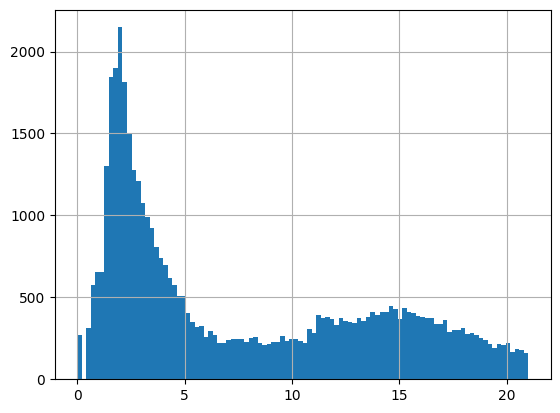

In [123]:
Distribución_RMSD = df_CASP['RMSD'].hist(bins = 100)


In [119]:
df_Atributos_CASP = df_CASP.drop('RMSD', axis=1)

C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\409116603.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Atributos_CASP.hist(ax = ax, bins = 100)


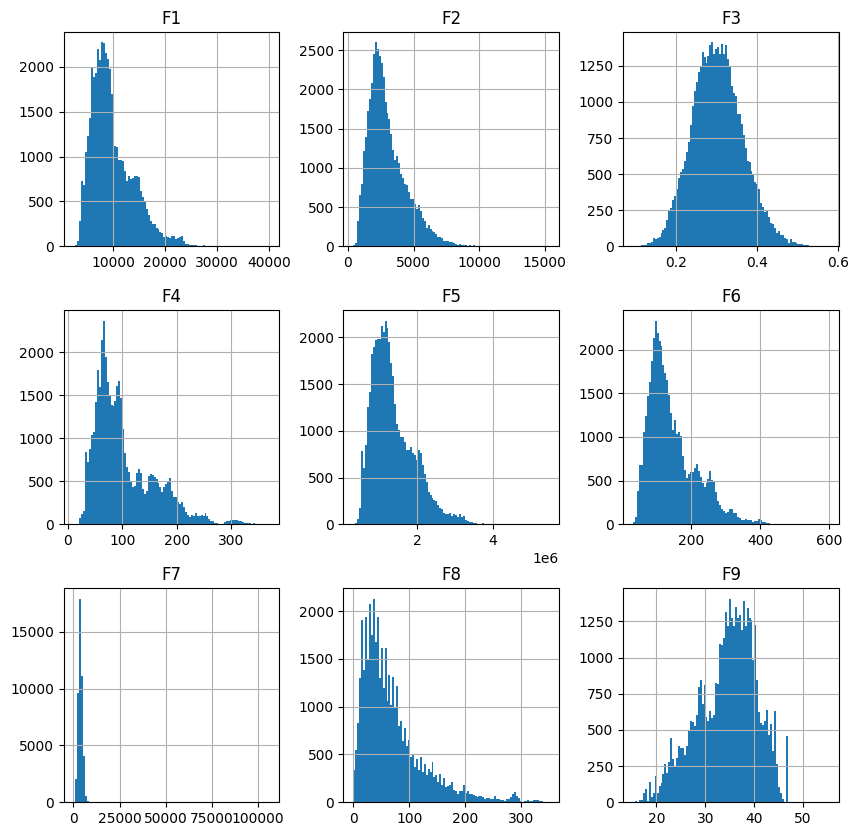

In [120]:
fig, ax =plt.subplots(figsize=(10,10))
df_Atributos_CASP.hist(ax = ax, bins = 100)
plt.show()

Se ve que F8 es discreta y además, que probablemente tiene la mayor parte de los valores agrupados y algunos aoutliers mas lejanos

279

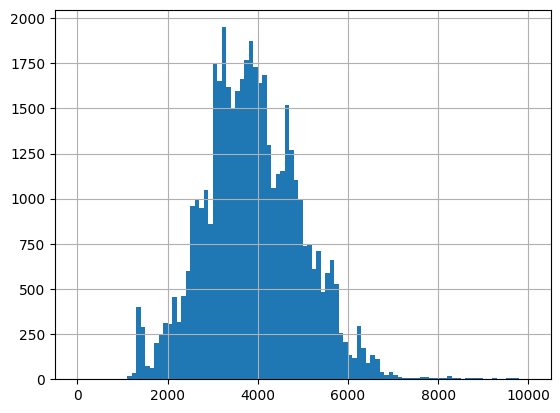

In [121]:
df_CASP['F7'].hist(bins = 100, range =[0,10000])
len(df_CASP[df_CASP['F7']>10000])

Aqui puede verse que hay solo 276 valores mayores a 10000. Este sería uana visión mas correcta de la distribución de F7.

Las variables están en rangos muy diversos, es por esto que se decide normalizarlas para estandarizar los atributos.

C:\Users\pedro\AppData\Local\Temp\ipykernel_26552\1637987520.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_Atributos_CASP_norm.hist(ax = ax, bins = 100)


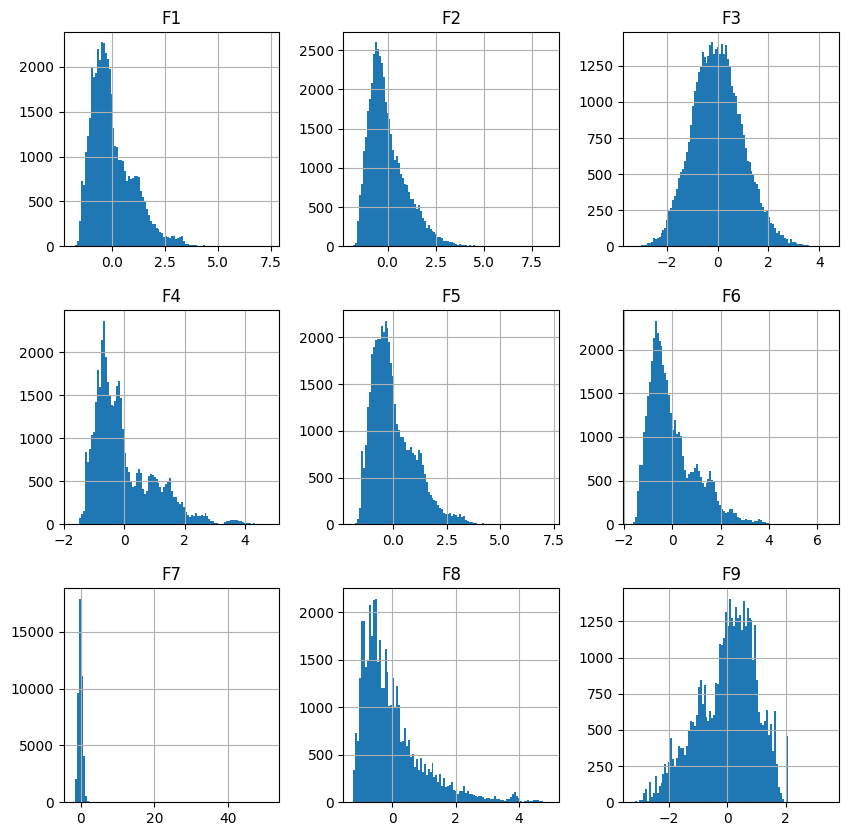

In [125]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_Atributos_CASP)
scaled = scaler.fit_transform(df_Atributos_CASP)

df_Atributos_CASP_norm = pd.DataFrame(scaled, columns = df_Atributos_CASP.keys())
fig, ax =plt.subplots(figsize=(10,10))
df_Atributos_CASP_norm.hist(ax = ax, bins = 100)
plt.show()

## Regresion

### Regresión linear con SKLEARN

Se buscará ahora hacer una regresión linear utilizando regresión logística. Se probará con los atributos como parametros de entrada, con features polinomeales de orden 2, 3 y 4. Se buscará la cantidad optima de features polinomiales utilizando un conjunto de validación. 
La regresión sin features polinomiales se realizará de manera analoga al caso de clasificación, en el sentido de que se buscará nuevamente la cantidad optima de atributos como se hizo antes y de eligirá el modelo mas certero (osea, el de menor MSE).

#### Sin features polinomiales

In [128]:
metricas = ["neg_mean_squared_error","r2"]
clf_linear = LinearRegression()
df_regresión = df_CASP["RMSD"]
df_linear, atrib_linear = clasificador(clf_linear, metricas, df_Atributos_CASP_norm,df_regresión , 5)

maximos=(maximos_scores(metricas, atrib_linear, df_linear))



El neg_mean_squared_error maximo es:  -26.88319583379789 , usando los atributos:  ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']
El r2 maximo es:  0.2817158049007813 , usando los atributos:  ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']


#### Con features polinomiales, viendo el maximo r^2 y mínimo error cuadrático medio utilizando todos los atributos y validación cruzada

In [135]:
poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)
poly4 = PolynomialFeatures(4)
poly5 = PolynomialFeatures(5)
clf_linear = LinearRegression()
df_linear_poly_test_2, df_linear_poly_train_2 = clasificador(clf_linear, metricas, df_Atributos_CASP_norm, df_regresión, 5, poly = poly2)

df_linear_poly_test_3, df_linear_poly_train_3 = clasificador(clf_linear, metricas, df_Atributos_CASP_norm, df_regresión, 5, poly = poly3)

df_linear_poly_test_4, df_linear_poly_train_4 = clasificador(clf_linear, metricas, df_Atributos_CASP_norm, df_regresión, 5, poly = poly4)

df_linear_poly_test_5, df_linear_poly_train_5 = clasificador(clf_linear, metricas, df_Atributos_CASP_norm, df_regresión, 5, poly = poly5)

In [136]:
print("Test Scores: orden 2")
print(df_linear_poly_test_2)
print("Train Scores: orden 2")
print(df_linear_poly_train_2)

print("Test Scores: orden 3")
print(df_linear_poly_test_3)
print("Train Scores: orden 3")
print(df_linear_poly_train_3)

print("Test Scores: orden 4")
print(df_linear_poly_test_4)
print("Train Scores: orden 4")
print(df_linear_poly_train_4)

print("Test Scores: orden 5")
print(df_linear_poly_test_5)
print("Train Scores: orden 5")
print(df_linear_poly_train_5)

Test Scores: orden 2
   neg_mean_squared_error        r2
0              -23.774358  0.364851
Train Scores: orden 2
   neg_mean_squared_error       r2
0              -23.662403  0.36787
Test Scores: orden 3
   neg_mean_squared_error       r2
0              -29.782743  0.20618
Train Scores: orden 3
   neg_mean_squared_error        r2
0              -21.181641  0.434143
Test Scores: orden 4
   neg_mean_squared_error         r2
0            -3425.291787 -90.546601
Train Scores: orden 4
   neg_mean_squared_error        r2
0              -19.120945  0.489194
Test Scores: orden 5
   neg_mean_squared_error             r2
0           -2.645294e+07 -704117.282892
Train Scores: orden 5
   neg_mean_squared_error        r2
0              -16.385216  0.562278


Puede verse como a partir de orden 4 en adelante, para el conjunto de testeo, el error aumenta enormemente pero para el conjunto de entrenamiento es cada vez menor el error y mayor el r^2 (osea, el modelo se ajusta mejor). Esto indica que hay un overfitting muy elevado en ordenes mayores a 3, ya que el regresor se está adaptando demasiado a los datos de entrenamiento, dejando muy poco margen para cualquier npunto que no caiga dentro de este conjunto.

Tambien puede verse como con features polinomiales de orden 2, el r^2 es mas elevado y el MSE es mas bajo, por lo el regresor se adapta mejor haciendo esta transformación.
Sin embargo, en orden 3, aunque no se va completamente de orden como con orden 4 y 5, sigue siendo peor la performance que con features polinomiales de orden 2 y que sin features polinomiales. Esto, sumado a una mejor performance en el training, indica que tambien hay overfitting con features polinomiales de orden 3.

#### Análisis de features polinomiales con conjunto de validación

Uso 80% para entrenamiento, 10% para testeo y 10% para validación

In [155]:
atributos = list(df_Atributos_CASP_norm.keys())

for i in range(1,6):
    poly =  PolynomialFeatures(i)
    df_Atributos_CASP_norm_mejores = poly.fit_transform(df_Atributos_CASP_norm[atributos].values)
    X_train, X_rem, y_train, y_rem = train_test_split(df_Atributos_CASP_norm_mejores, df_regresión, test_size= 0.8, random_state= 26)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=False)
    clf_linear = LinearRegression()
    clf_linear.fit(X_train,y_train)
    prediccion = clf_linear.predict(X_valid)
    print("Para features polinomiales de orden ",i)

    print("Error cuadrático medio: %.2f" % metrics.mean_squared_error(y_valid, prediccion))

    print("r^2: %.2f" % metrics.r2_score(y_valid, prediccion))


Para features polinomiales de orden  1
Error cuadrático medio: 26.97
r^2: 0.28
Para features polinomiales de orden  2
Error cuadrático medio: 32.69
r^2: 0.13
Para features polinomiales de orden  3
Error cuadrático medio: 465.60
r^2: -11.42
Para features polinomiales de orden  4
Error cuadrático medio: 2568539.84
r^2: -68525.45
Para features polinomiales de orden  5
Error cuadrático medio: 78145052079.77
r^2: -2084843197.06


Dado que con 2 features da el mejor resultado, se usaran 2 para el testeo, que dará el resultado definitivo.

In [156]:
poly =  PolynomialFeatures(2)
df_Atributos_CASP_norm_mejores = poly.fit_transform(df_Atributos_CASP_norm[atributos].values)
X_train, X_rem, y_train, y_rem = train_test_split(df_Atributos_CASP_norm_mejores, df_regresión, test_size= 0.8, random_state= 26)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=False)
clf_linear = LinearRegression()
clf_linear.fit(X_train,y_train)
prediccion = clf_linear.predict(X_test)
print("Para features polinomiales de orden ",2)

print("Error cuadrático medio: %.2f" % metrics.mean_squared_error(y_test, prediccion))

print("r^2: %.2f" % metrics.r2_score(y_test, prediccion))

Para features polinomiales de orden  2
Error cuadrático medio: 27.14
r^2: 0.27


# KERAS

Ahora intentare aplicar con keras regresión logistica (para clasificar YEAST) y lineal (Para clasificar CASP)

## Regresión logística

Uso Stochastic Gradient Descent como funcion de activación

In [204]:
df_YEAST_mult = df_YEAST[df_YEAST['class'].isin(["NUC","CYT","MIT","ME3"])]

df_atributos = df_YEAST_mult.drop(["class","Seq Name"], axis=1)
df_clases = df_YEAST_mult.drop(features1, axis=1)
df_clases = df_clases.drop("Seq Name", axis=1)

atributos = list(df_atributos.keys())

enc = LabelEncoder()
df_clases = enc.fit_transform(df_clases)
clases = np.unique(df_clases)

X_train, X_test, y_train, y_test = train_test_split(df_atributos, df_clases, test_size= 0.8, random_state= 26)

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Con una capa densa

In [205]:
model = Sequential()

model.add(Dense(1, input_shape = (6,), activation = "sigmoid"))
model.compile(optimizer = SGD(1e-2), loss ="binary_crossentropy", metrics = ["accuracy"])
history1 = model.fit(x= X_train[atributos].values, y =y_train, validation_data = (X_test[atributos].values, y_test), epochs = 100 , batch_size = 200 )

Epoch 1/100
2/2 [==============================] - 1s 288ms/step - loss: 2.1781 - accuracy: 0.3977 - val_loss: 2.3235 - val_accuracy: 0.3462
Epoch 2/100
2/2 [==============================] - 0s 56ms/step - loss: 2.1223 - accuracy: 0.3977 - val_loss: 2.2594 - val_accuracy: 0.3462
Epoch 3/100
2/2 [==============================] - 0s 57ms/step - loss: 2.0663 - accuracy: 0.3977 - val_loss: 2.2002 - val_accuracy: 0.3462
Epoch 4/100
2/2 [==============================] - 0s 56ms/step - loss: 2.0134 - accuracy: 0.3977 - val_loss: 2.1404 - val_accuracy: 0.3462
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 1.9598 - accuracy: 0.3977 - val_loss: 2.0785 - val_accuracy: 0.3462
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 1.9058 - accuracy: 0.3977 - val_loss: 2.0217 - val_accuracy: 0.3462
Epoch 7/100
2/2 [==============================] - 0s 63ms/step - loss: 1.8544 - accuracy: 0.3977 - val_loss: 1.9609 - val_accuracy: 0.3462
Epoch 8/100
2/2 [==

### Con dos capas densas y relu en la capa oculta

In [206]:
model = Sequential()

model.add(Dense(100, activation = "relu"))
model.add(Dense(1, input_shape = (6,), activation = "sigmoid"))
model.compile(optimizer = SGD(1e-2), loss ="binary_crossentropy", metrics = ["accuracy"])
history2 = model.fit(x= X_train[atributos].values, y =y_train, validation_data = (X_test[atributos].values, y_test), epochs = 100 , batch_size = 200 )


Epoch 1/100
2/2 [==============================] - 0s 131ms/step - loss: 0.6286 - accuracy: 0.0927 - val_loss: 0.5513 - val_accuracy: 0.1260
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 0.5647 - accuracy: 0.1236 - val_loss: 0.4772 - val_accuracy: 0.1260
Epoch 3/100
2/2 [==============================] - 0s 30ms/step - loss: 0.5005 - accuracy: 0.1236 - val_loss: 0.3990 - val_accuracy: 0.1260
Epoch 4/100
2/2 [==============================] - 0s 28ms/step - loss: 0.4351 - accuracy: 0.1236 - val_loss: 0.3283 - val_accuracy: 0.1260
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3738 - accuracy: 0.1236 - val_loss: 0.2480 - val_accuracy: 0.1260
Epoch 6/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3095 - accuracy: 0.1236 - val_loss: 0.1894 - val_accuracy: 0.1260
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 0.2596 - accuracy: 0.1236 - val_loss: 0.1283 - val_accuracy: 0.1260
Epoch 8/100
2/2 [==

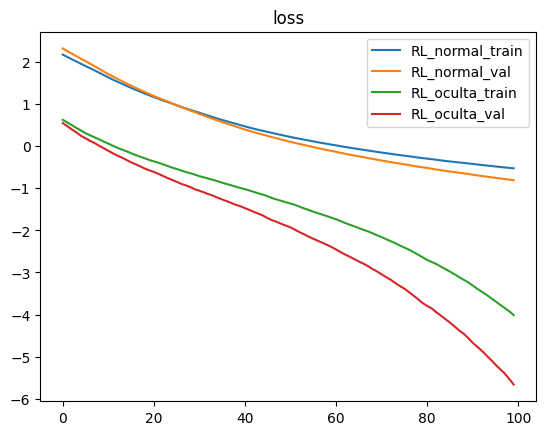

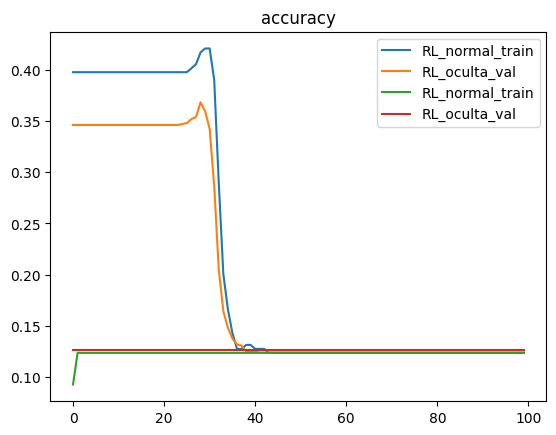

In [207]:

plt.plot(history1.history["loss"],label="RL_normal_train")
plt.plot(history1.history["val_loss"],label="RL_normal_val")
plt.plot(history2.history["loss"],label="RL_oculta_train")
plt.plot(history2.history["val_loss"],label="RL_oculta_val")
plt.title("loss")
plt.legend()
plt.show()

plt.plot(history1.history["accuracy"],label="RL_normal_train")
plt.plot(history1.history["val_accuracy"],label="RL_oculta_val")
plt.plot(history2.history["accuracy"],label="RL_normal_train")
plt.plot(history2.history["val_accuracy"],label="RL_oculta_val")
plt.title("accuracy")
plt.legend()
plt.show()

## Regresión Lineal

In [213]:
X_train, X_test, y_train, y_test = train_test_split(df_Atributos_CASP_norm, df_regresión, test_size= 0.7, random_state= 26)
atributos = list(df_Atributos_CASP_norm.keys())

In [214]:
model = Sequential()

model.add(Dense(1, input_shape = (9,), activation = "linear"))
model.compile(optimizer = SGD(1e-2), loss ="mse")
history3 = model.fit(x= X_train[atributos].values, y =y_train, validation_data = (X_test[atributos].values, y_test), epochs = 100 , batch_size = 200)

Epoch 1/100
69/69 [==============================] - 0s 4ms/step - loss: 54.3538 - val_loss: 35.1216
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 31.4673 - val_loss: 30.1809
Epoch 3/100
69/69 [==============================] - 0s 3ms/step - loss: 29.3825 - val_loss: 29.2835
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 28.7095 - val_loss: 28.7894
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 28.2585 - val_loss: 28.3644
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 27.9140 - val_loss: 28.0380
Epoch 7/100
69/69 [==============================] - 0s 4ms/step - loss: 27.6506 - val_loss: 27.8199
Epoch 8/100
69/69 [==============================] - 0s 4ms/step - loss: 27.4370 - val_loss: 27.7070
Epoch 9/100
69/69 [==============================] - 0s 4ms/step - loss: 27.2852 - val_loss: 27.4934
Epoch 10/100
69/69 [==============================] - 0s 4ms/step - loss: 27.1590 - val_los

In [215]:
model = Sequential()
model.add(Dense(100, activation = "relu"))
model.add(Dense(1, input_shape = (9,), activation = "linear"))
model.compile(optimizer = SGD(1e-2), loss ="mse")
history4 = model.fit(x= X_train[atributos].values, y =y_train, validation_data = (X_test[atributos].values, y_test), epochs = 100 , batch_size = 200)


Epoch 1/100
69/69 [==============================] - 1s 4ms/step - loss: 35.9197 - val_loss: 27.6083
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 26.4877 - val_loss: 26.9287
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 25.8424 - val_loss: 25.8540
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 25.5754 - val_loss: 25.6934
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 25.2975 - val_loss: 25.4124
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 25.1363 - val_loss: 26.8319
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 24.9419 - val_loss: 24.9656
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 24.8010 - val_loss: 25.5777
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 24.5557 - val_loss: 24.7029
Epoch 10/100
69/69 [==============================] - 0s 3ms/step - loss: 24.5410 - val_los

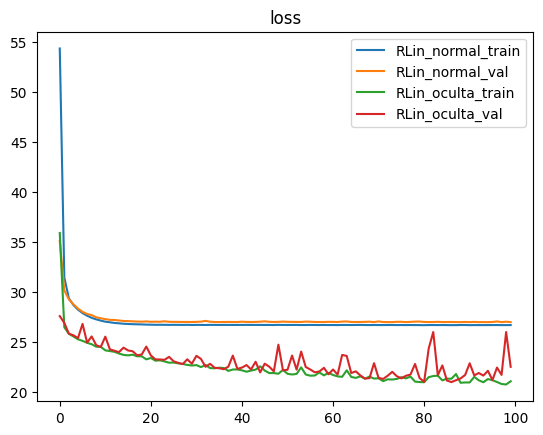

In [216]:
plt.plot(history3.history["loss"],label="RLin_normal_train")
plt.plot(history3.history["val_loss"],label="RLin_normal_val")
plt.plot(history4.history["loss"],label="RLin_oculta_train")
plt.plot(history4.history["val_loss"],label="RLin_oculta_val")
plt.title("loss")
plt.legend()
plt.show()